# SQL-Based Exploratory Analysis of Credit Risk

This notebook explores a cleaned credit risk dataset using SQL queries. The data has been preprocessed to remove outliers and engineered to include features such as income brackets, age groups, debt ratio categories, and credit utilization bands.

The goal is to use SQLite and SQL queries executed via Python to answer key questions related to borrower delinquency.


## Setup

In [34]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../data/clean_credit_risk.csv')
connection_object = sqlite3.connect('../database/credit_risk.db')
df.to_sql('credit_risk', connection_object, if_exists='replace', index=False)

16182

## Analysis

### What share of borrowers defaulted?

In [30]:
query = """
SELECT AVG(dlq_2yrs) AS default_rate
FROM credit_risk;
"""
display(pd.read_sql_query(query, connection_object))

,default_rate
0,0.496539



#### Insight:

Roughly **49.7%** of borrowers in the dataset defaulted, indicating a high-risk borrower pool. The default rate is surprisingly high and may be the result of the dataset being balanced or limited to higher-risk applicants. Regardless, this value acts as a **baseline** for comparing subgroup risk levels in later queries.


### How many borrowers have never been late vs. those who have?


In [31]:
query = """
SELECT 
  SUM(total_late = 0) AS never_late,
  SUM(total_late > 0) AS late
FROM credit_risk;
"""
display(pd.read_sql_query(query, connection_object))


,never_late,late
0,9434,6748



#### Insight:

The majority of borrowers (about 58%) have **no late payments**, suggesting that not all borrowers with high debt ratios or utilization are equally risky. This segmentation lays the groundwork for more **targeted comparisons** based on behavior, not just financials.


### Default Rate by Age Group   

In [32]:
query = """
SELECT age_group, AVG(dlq_2yrs) AS default_rate
FROM credit_risk
WHERE age_group IS NOT NULL
GROUP BY age_group
ORDER BY 
  CASE age_group
    WHEN '<30' THEN 1
    WHEN '30–45' THEN 2
    WHEN '45–60' THEN 3
    WHEN '60+' THEN 4
  END;
"""
display(pd.read_sql_query(query, connection_object))

,age_group,default_rate
0,<30,0.623265
1,30–45,0.574607
2,45–60,0.499832
3,60+,0.310335


#### Insight:

Borrowers under 30 have the **highest delinquency rate** (~62%), while those 60+ are the **least risky** (~31%). This likely reflects factors such as credit history length, income stability, and financial responsibility with age.


### Default rate by Income bracket

,income_bracket,default_rate
0,<2.5k,0.577396
1,2.5k–5k,0.550175
2,5k–10k,0.457244
3,10k+,0.366810


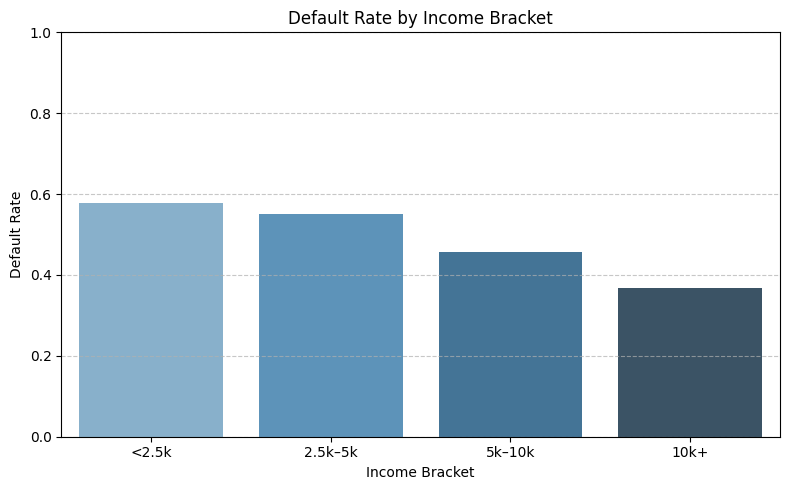

In [38]:
query = """
SELECT income_bracket, AVG(dlq_2yrs) AS default_rate
FROM credit_risk
GROUP BY income_bracket
ORDER BY 
  CASE income_bracket
    WHEN '<2.5k' THEN 1
    WHEN '2.5k–5k' THEN 2
    WHEN '5k–10k' THEN 3
    WHEN '10k+' THEN 4
  END;
"""
display(pd.read_sql_query(query, connection_object))
df_income = pd.read_sql_query(query, connection_object)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_income,
    x='income_bracket',
    y='default_rate',
    hue='income_bracket',          
    palette='Blues_d',
    legend=False               
)
plt.title('Default Rate by Income Bracket')
plt.ylabel('Default Rate')
plt.xlabel('Income Bracket')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Insight:

There is a **clear inverse relationship** between income and default rate. Borrowers earning under $2.5k/month have a **default rate of nearly 58%**, while those earning over $10k/month default at a significantly lower rate of **36.7%**.

This suggests that **income is a strong indicator of credit risk**, and segmenting borrowers by income can help prioritize lending strategies and risk management policies.
